# **Loan Default Prediction Challenge**

**Problem description**

SuperLender is a local digital lending company, which prides itself in its effective use of credit risk models to deliver profitable and high-impact loan alternative. Its assessment approach is based on two main risk drivers of loan default prediction:. 1) willingness to pay and 2) ability to pay. Since not all customers pay back, the company invests in experienced data scientist to build robust models to effectively predict the odds of repayment.

These two fundamental drivers need to be determined at the point of each application to allow the credit grantor to make a calculated decision based on repayment odds, which in turn determines if an applicant should get a loan, and if so - what the size, price and tenure of the offer will be.

There are two types of risk models in general: New business risk, which would be used to assess the risk of application(s) associated with the first loan that he/she applies. The second is a repeat or behaviour risk model, in which case the customer has been a client and applies for a repeat loan. In the latter case - we will have additional performance on how he/she repaid their prior loans, which we can incorporate into our risk model.

It is your job to predict if a loan was good or bad, i.e. accurately predict binary outcome variable, where Good is 1 and Bad is 0.

A good loan means the borrower paid it back in time, and a bad loan means the borrower defaulted because they have not made their scheduled payments for a predetermined amount of time.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install category_encoders
!pip install pandas-profiling xgboost gradio


Let's first import some libraries.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import joblib
from datetime import datetime, date
import calendar
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from ydata_profiling import ProfileReport
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

Let's have a look at the data provided in our datasets:
First we load and store them in appropriately named variables.
**demo** contains demographic data of people taking out loans as follows:

a) Demographic data (traindemographics.csv)

*   customerid (Primary key used to merge to other data)
*   birthdate (date of birth of the customer)
*   bank_account_type (type of primary bank account)
*   longitude_gps
*   latitude_gps
*   bank_name_clients (name of the bank)
*   bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)
*   employment_status_clients (type of employment that customer has)
*   level_of_education_clients (highest level of education)

In [ ]:
demo = pd.read_csv('/content/drive/MyDrive/Classroom/loan_data/traindemographics.csv')
demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


**perf** contains data of the repeat loan that the customer has taken for which we need to predict the performance of. This is the current loan data, but we are predicting whether this loan would default given all previous loans and demographics of the customer. It has the following descriptions:

b) Performance data (trainperf.csv) :

*   customerid (Primary key used to merge to other data)
*   systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
*   loannumber (The number of the loan that you have to predict)
*   approveddate (Date that loan was approved)
*   creationdate (Date that loan application was created)
*   loanamount (Loan value taken)
*   totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
*   termdays (Term of loan)
*   referredby (customerId of the customer that referred this person - is missing, then not referred)
*   good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predict


In [ ]:
perf = pd.read_csv('/content/drive/MyDrive/Classroom/loan_data/trainperf.csv')
perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


**prev** has all previous loans that the customer had prior to the loan above (perf) that we want to predict the performance of. Each loan has a different systemloanid, but the same customerid for each customer.

c) Previous loans data (trainprevloans.csv) :

*   customerid (Primary key used to merge to other data)
*   systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
*   loannumber (The number of the loan that you have to predict)
*   approveddate (Date that loan was approved)
*   creationdate (Date that loan application was created)
*   loanamount (Loan value taken)
*   totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
*   termdays (Term of loan)
*   closeddate (Date that the loan was settled)
*   referredby (customerId of the customer that referred this person - is missing, then not referred)
*   firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
*   firstrepaiddate (Actual date that he/she paid the first payment as defined above)



I think its important to note that the columns in perf and prev are the same in name save for **closed date, firstduedate** and **firstrepaiddate** in prev, and the **good_bad_flag** in perf.

In [ ]:
prev = pd.read_csv('/content/drive/MyDrive/Classroom/loan_data/trainprevloans.csv')
prev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


# **Preliminary understanding of the datasets' shapes.**

In [ ]:
demo.dtypes

customerid                     object
birthdate                      object
bank_account_type              object
longitude_gps                 float64
latitude_gps                  float64
bank_name_clients              object
bank_branch_clients            object
employment_status_clients      object
level_of_education_clients     object
dtype: object

In [ ]:
demo.shape

(4346, 9)

In [ ]:
perf.dtypes

customerid        object
systemloanid       int64
loannumber         int64
approveddate      object
creationdate      object
loanamount       float64
totaldue         float64
termdays           int64
referredby        object
good_bad_flag     object
dtype: object

In [ ]:
perf.shape

(4368, 10)

In [ ]:
prev.dtypes

customerid          object
systemloanid         int64
loannumber           int64
approveddate        object
creationdate        object
loanamount         float64
totaldue           float64
termdays             int64
closeddate          object
referredby          object
firstduedate        object
firstrepaiddate     object
dtype: object

In [ ]:
prev.shape

(18183, 12)

Some data cleaning.

In [ ]:
demo.isnull().sum()

customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           4295
employment_status_clients      648
level_of_education_clients    3759
dtype: int64

In [ ]:
demo_dup = demo.duplicated().any()
demo_dup

True

In [ ]:
dup_count = demo.duplicated().sum()
dup_count

12

In [ ]:
demo = demo.drop_duplicates()

In [ ]:
demo.shape

(4334, 9)

In [ ]:
demo = demo.drop(columns=['bank_branch_clients'])

In [ ]:
demo.shape

(4334, 8)

In [ ]:
demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,Permanent,NaN


In [ ]:
dup_count1 = perf.duplicated().sum()
dup_count1

0

In [ ]:
perf.isnull().sum()

customerid          0
systemloanid        0
loannumber          0
approveddate        0
creationdate        0
loanamount          0
totaldue            0
termdays            0
referredby       3781
good_bad_flag       0
dtype: int64

In [ ]:
perf = perf.drop(columns=['referredby'])

In [ ]:
perf.shape

(4368, 9)

In [ ]:
dup_count2 = prev.duplicated().sum()
dup_count2

0

In [ ]:
prev.isnull().sum()

customerid             0
systemloanid           0
loannumber             0
approveddate           0
creationdate           0
loanamount             0
totaldue               0
termdays               0
closeddate             0
referredby         17157
firstduedate           0
firstrepaiddate        0
dtype: int64

In [ ]:
prev = prev.drop(columns=['referredby'])

In [ ]:
prev.shape

(18183, 11)

As **'customerid'** is the primary key, I tried to ensure there were similar values in all the datasets.

In [ ]:
demo['customerid'].isin(perf['customerid']).value_counts()

customerid
True     3269
False    1065
Name: count, dtype: int64

In [ ]:
prev['customerid'].isin(perf['customerid']).value_counts()

customerid
True    18183
Name: count, dtype: int64

In [ ]:
demo['customerid'].isin(prev['customerid']).value_counts()

customerid
True     3264
False    1070
Name: count, dtype: int64

From this information we can conclude that there are shared values in the customerid columns of demo, prev and perf datasets.

In [ ]:
demo.columns

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'employment_status_clients',
       'level_of_education_clients'],
      dtype='object')

In [ ]:
perf.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'good_bad_flag'],
      dtype='object')

In [ ]:
prev.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'firstduedate', 'firstrepaiddate'],
      dtype='object')

In [ ]:
prev['systemloanid'].isin(perf['systemloanid']).value_counts()

systemloanid
False    18183
Name: count, dtype: int64

In [ ]:
prev['approveddate'].isin(perf['approveddate']).value_counts()

approveddate
False    18182
True         1
Name: count, dtype: int64

In [ ]:
prev['loannumber'].isin(perf['loannumber']).value_counts()

loannumber
True     13836
False     4347
Name: count, dtype: int64

While perf and prev have intersecting data in some columns, it is not enough to justify merging all of them. For this reason, we are going to rename the columns in one dataset to separate the information.

In [ ]:
perf.columns = ['customerid','perfsystemloanid','perf_loannumber','perf_approveddate','perf_creationdate',
                'perf_loanamount','perf_totaldue','perf_termdays','good_bad_flag']

In [ ]:
perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         4368 non-null   object 
 1   perfsystemloanid   4368 non-null   int64  
 2   perf_loannumber    4368 non-null   int64  
 3   perf_approveddate  4368 non-null   object 
 4   perf_creationdate  4368 non-null   object 
 5   perf_loanamount    4368 non-null   float64
 6   perf_totaldue      4368 non-null   float64
 7   perf_termdays      4368 non-null   int64  
 8   good_bad_flag      4368 non-null   object 
dtypes: float64(2), int64(3), object(4)
memory usage: 307.2+ KB


In [ ]:
loandata = pd.merge(prev, perf, on='customerid')
loandata.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate,perfsystemloanid,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good
3,8a2a81a74ce8c05d014cfb32a0da1049,301923941,10,2017-06-01 13:34:30.000000,2017-06-01 12:34:21.000000,20000.0,24500.0,30,2017-06-25 15:24:06.000000,2017-07-03 00:00:00.000000,2017-06-25 15:13:56.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good
4,8a2a81a74ce8c05d014cfb32a0da1049,301954468,11,2017-06-28 10:58:34.000000,2017-06-28 09:58:25.000000,20000.0,24500.0,30,2017-07-25 08:14:36.000000,2017-07-31 00:00:00.000000,2017-07-25 08:04:27.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good


In [ ]:
loan_data = pd.merge(demo, loandata, on='customerid')
loan_data.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,systemloanid,loannumber,...,firstduedate,firstrepaiddate,perfsystemloanid,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,good_bad_flag
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,301943951,1,...,2017-07-05 00:00:00.000000,2017-07-04 17:59:36.000000,301964962,2,2017-07-05 14:29:48.000000,2017-07-05 13:29:42.000000,10000.0,13000.0,30,Good
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,Permanent,NaN,301929966,1,...,2017-07-07 00:00:00.000000,2017-07-10 08:42:44.000000,301972172,2,2017-07-10 21:21:46.000000,2017-07-10 20:21:40.000000,10000.0,13000.0,30,Bad
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,301931228,3,...,2017-07-10 00:00:00.000000,2017-07-11 10:02:11.000000,301976271,4,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,10000.0,13000.0,30,Good
3,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,301895253,1,...,2017-05-23 00:00:00.000000,2017-05-27 12:52:45.000000,301976271,4,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,10000.0,13000.0,30,Good
4,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,301919784,2,...,2017-06-12 00:00:00.000000,2017-06-08 11:03:40.000000,301976271,4,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,10000.0,13000.0,30,Good


In [ ]:
loan_data.shape

(13673, 26)

In [ ]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13673 entries, 0 to 13672
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  13673 non-null  object 
 1   birthdate                   13673 non-null  object 
 2   bank_account_type           13673 non-null  object 
 3   longitude_gps               13673 non-null  float64
 4   latitude_gps                13673 non-null  float64
 5   bank_name_clients           13673 non-null  object 
 6   employment_status_clients   12310 non-null  object 
 7   level_of_education_clients  3464 non-null   object 
 8   systemloanid                13673 non-null  int64  
 9   loannumber                  13673 non-null  int64  
 10  approveddate                13673 non-null  object 
 11  creationdate                13673 non-null  object 
 12  loanamount                  13673 non-null  float64
 13  totaldue                    136

**'level_of_education_clients'** has too many null values to justify working with it further to train the model.



In [ ]:
loan_data = loan_data.drop(columns=['level_of_education_clients'])

In [ ]:
loan_data.shape

(13673, 25)

In [ ]:
loan_data.head(15)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,systemloanid,loannumber,approveddate,...,firstduedate,firstrepaiddate,perfsystemloanid,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,good_bad_flag
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,301943951,1,2017-06-19 17:55:26.000000,...,2017-07-05 00:00:00.000000,2017-07-04 17:59:36.000000,301964962,2,2017-07-05 14:29:48.000000,2017-07-05 13:29:42.000000,10000.0,13000.0,30,Good
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,Permanent,301929966,1,2017-06-07 12:47:30.000000,...,2017-07-07 00:00:00.000000,2017-07-10 08:42:44.000000,301972172,2,2017-07-10 21:21:46.000000,2017-07-10 20:21:40.000000,10000.0,13000.0,30,Bad
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,301931228,3,2017-06-08 11:49:34.000000,...,2017-07-10 00:00:00.000000,2017-07-11 10:02:11.000000,301976271,4,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,10000.0,13000.0,30,Good
3,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,301895253,1,2017-05-08 11:07:01.000000,...,2017-05-23 00:00:00.000000,2017-05-27 12:52:45.000000,301976271,4,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,10000.0,13000.0,30,Good
4,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,301919784,2,2017-05-27 17:10:41.000000,...,2017-06-12 00:00:00.000000,2017-06-08 11:03:40.000000,301976271,4,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,10000.0,13000.0,30,Good
5,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,Permanent,301939781,1,2017-06-15 14:05:26.000000,...,2017-06-30 00:00:00.000000,2017-07-18 19:14:05.000000,301997763,2,2017-07-26 21:03:17.000000,2017-07-26 20:03:09.000000,10000.0,11500.0,15,Good
6,8a858ea05a859123015a8892914d15b7,1990-07-21 00:00:00.000000,Savings,3.365935,6.564823,Access Bank,Permanent,301876300,3,2017-04-21 21:59:19.000000,...,2017-05-22 00:00:00.000000,2017-05-22 22:29:52.000000,301992494,6,2017-07-23 21:44:43.000000,2017-07-23 20:44:36.000000,20000.0,24500.0,30,Good
7,8a858ea05a859123015a8892914d15b7,1990-07-21 00:00:00.000000,Savings,3.365935,6.564823,Access Bank,Permanent,301953421,5,2017-06-27 13:07:32.000000,...,2017-07-27 00:00:00.000000,2017-07-21 21:47:08.000000,301992494,6,2017-07-23 21:44:43.000000,2017-07-23 20:44:36.000000,20000.0,24500.0,30,Good
8,8a858ea05a859123015a8892914d15b7,1990-07-21 00:00:00.000000,Savings,3.365935,6.564823,Access Bank,Permanent,301916071,4,2017-05-23 08:56:10.000000,...,2017-06-22 00:00:00.000000,2017-06-22 20:11:56.000000,301992494,6,2017-07-23 21:44:43.000000,2017-07-23 20:44:36.000000,20000.0,24500.0,30,Good
9,8a858ea05a859123015a8892914d15b7,1990-07-21 00:00:00.000000,Savings,3.365935,6.564823,Access Bank,Permanent,301849134,2,2017-03-29 11:10:12.000000,...,2017-04-28 00:00:00.000000,2017-04-21 21:30:48.000000,301992494,6,2017-07-23 21:44:43.000000,2017-07-23 20:44:36.000000,20000.0,24500.0,30,Good


Let's take note of the numerical and non-numerical columns to decide what approach to take next:

In [ ]:
loan_data.columns

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'employment_status_clients',
       'systemloanid', 'loannumber', 'approveddate', 'creationdate',
       'loanamount', 'totaldue', 'termdays', 'closeddate', 'firstduedate',
       'firstrepaiddate', 'perfsystemloanid', 'perf_loannumber',
       'perf_approveddate', 'perf_creationdate', 'perf_loanamount',
       'perf_totaldue', 'perf_termdays', 'good_bad_flag'],
      dtype='object')

In [ ]:
categorical = [var for var in loan_data.columns if loan_data[var].dtype == 'O']
print('There are {} categorical variables \n'.format(len(categorical)))
print('They are: ', categorical)

There are 13 categorical variables 

They are:  ['customerid', 'birthdate', 'bank_account_type', 'bank_name_clients', 'employment_status_clients', 'approveddate', 'creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate', 'perf_approveddate', 'perf_creationdate', 'good_bad_flag']


In [ ]:
numerical = [var for var in loan_data.columns if loan_data[var].dtype != 'O']
print('There are {} numerical variables \n'.format(len(numerical)))
print('They are: ', numerical)

There are 12 numerical variables 

They are:  ['longitude_gps', 'latitude_gps', 'systemloanid', 'loannumber', 'loanamount', 'totaldue', 'termdays', 'perfsystemloanid', 'perf_loannumber', 'perf_loanamount', 'perf_totaldue', 'perf_termdays']


In [ ]:
loan_data[numerical].head()

,longitude_gps,latitude_gps,systemloanid,loannumber,loanamount,totaldue,termdays,perfsystemloanid,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays
0,3.319219,6.528604,301943951,1,10000.0,11500.0,15,301964962,2,10000.0,13000.0,30
1,3.325598,7.119403,301929966,1,10000.0,13000.0,30,301972172,2,10000.0,13000.0,30
2,5.746100,5.563174,301931228,3,10000.0,13000.0,30,301976271,4,10000.0,13000.0,30
3,5.746100,5.563174,301895253,1,10000.0,11500.0,15,301976271,4,10000.0,13000.0,30
4,5.746100,5.563174,301919784,2,10000.0,11500.0,15,301976271,4,10000.0,13000.0,30


In [ ]:
loan_data[categorical].head()

,customerid,birthdate,bank_account_type,bank_name_clients,employment_status_clients,approveddate,creationdate,closeddate,firstduedate,firstrepaiddate,perf_approveddate,perf_creationdate,good_bad_flag
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,GT Bank,NaN,2017-06-19 17:55:26.000000,2017-06-19 16:54:19.000000,2017-07-04 18:09:47.000000,2017-07-05 00:00:00.000000,2017-07-04 17:59:36.000000,2017-07-05 14:29:48.000000,2017-07-05 13:29:42.000000,Good
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,Sterling Bank,Permanent,2017-06-07 12:47:30.000000,2017-06-07 11:46:22.000000,2017-07-10 08:52:54.000000,2017-07-07 00:00:00.000000,2017-07-10 08:42:44.000000,2017-07-10 21:21:46.000000,2017-07-10 20:21:40.000000,Bad
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,Fidelity Bank,NaN,2017-06-08 11:49:34.000000,2017-06-08 10:49:27.000000,2017-07-11 10:12:20.000000,2017-07-10 00:00:00.000000,2017-07-11 10:02:11.000000,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,Good
3,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,Fidelity Bank,NaN,2017-05-08 11:07:01.000000,2017-05-08 10:06:40.000000,2017-05-27 13:02:53.000000,2017-05-23 00:00:00.000000,2017-05-27 12:52:45.000000,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,Good
4,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,Fidelity Bank,NaN,2017-05-27 17:10:41.000000,2017-05-27 16:10:34.000000,2017-06-08 11:13:50.000000,2017-06-12 00:00:00.000000,2017-06-08 11:03:40.000000,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,Good


# Dealing with categorical data.

We have to understand the categorical data we are working with, and look at its relationships with the data before we encode it.

In [ ]:
loan_data['birthdate'] = pd.to_datetime(loan_data['birthdate'])

In [ ]:
today = date.today()

In [ ]:
today

datetime.date(2024, 5, 5)

In [ ]:
loan_data['age'] = round(((datetime.now() - loan_data['birthdate'])/np.timedelta64(1, 'Y')),0)

In [ ]:
loan_data.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,systemloanid,loannumber,approveddate,...,firstrepaiddate,perfsystemloanid,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,good_bad_flag,age
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,NaN,301943951,1,2017-06-19 17:55:26.000000,...,2017-07-04 17:59:36.000000,301964962,2,2017-07-05 14:29:48.000000,2017-07-05 13:29:42.000000,10000.0,13000.0,30,Good,51.0
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,Permanent,301929966,1,2017-06-07 12:47:30.000000,...,2017-07-10 08:42:44.000000,301972172,2,2017-07-10 21:21:46.000000,2017-07-10 20:21:40.000000,10000.0,13000.0,30,Bad,38.0
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,301931228,3,2017-06-08 11:49:34.000000,...,2017-07-11 10:02:11.000000,301976271,4,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,10000.0,13000.0,30,Good,37.0
3,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,301895253,1,2017-05-08 11:07:01.000000,...,2017-05-27 12:52:45.000000,301976271,4,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,10000.0,13000.0,30,Good,37.0
4,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,301919784,2,2017-05-27 17:10:41.000000,...,2017-06-08 11:03:40.000000,301976271,4,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,10000.0,13000.0,30,Good,37.0


In [ ]:
age_pred = loan_data[['age','good_bad_flag']]
age_pred.head()

,age,good_bad_flag
0,51.0,Good
1,38.0,Bad
2,37.0,Good
3,37.0,Good
4,37.0,Good


<Axes: xlabel='good_bad_flag', ylabel='age'>

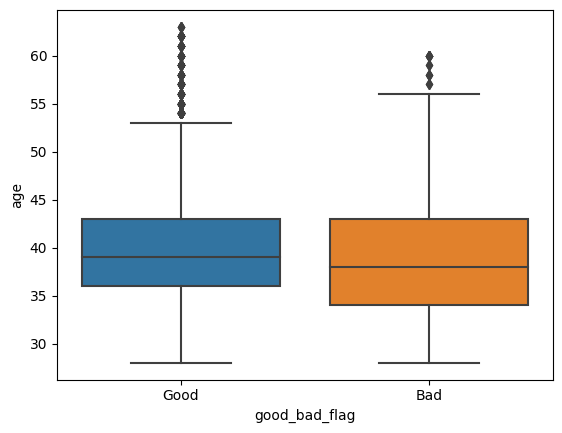

In [ ]:
sns.boxplot(x ="good_bad_flag",y="age" ,data = loan_data)

In [ ]:
loan_data['bank_account_type'].value_counts()

bank_account_type
Savings    8291
Other      5228
Current     154
Name: count, dtype: int64

In [ ]:
loan_data['bank_name_clients'].value_counts()

bank_name_clients
GT Bank               5028
First Bank            1932
Access Bank           1268
UBA                   1116
Diamond Bank           983
Zenith Bank            948
Stanbic IBTC           489
EcoBank                450
FCMB                   420
Skye Bank              271
Fidelity Bank          267
Sterling Bank          111
Wema Bank               88
Heritage Bank           87
Keystone Bank           83
Union Bank              74
Standard Chartered      44
Unity Bank              14
Name: count, dtype: int64

From the earlier data we know that 'employment_status_clients' has several N/A values so let's work on that.

In [ ]:
loan_data['employment_status_clients'].unique()

array([nan, 'Permanent', 'Student', 'Self-Employed', 'Unemployed',
       'Retired', 'Contract'], dtype=object)

In [ ]:
loan_data['employment_status_clients'].fillna("Employment_unknown", inplace=True)

In [ ]:
loan_data[categorical].head()

,customerid,birthdate,bank_account_type,bank_name_clients,employment_status_clients,approveddate,creationdate,closeddate,firstduedate,firstrepaiddate,perf_approveddate,perf_creationdate,good_bad_flag
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,GT Bank,Employment_unknown,2017-06-19 17:55:26.000000,2017-06-19 16:54:19.000000,2017-07-04 18:09:47.000000,2017-07-05 00:00:00.000000,2017-07-04 17:59:36.000000,2017-07-05 14:29:48.000000,2017-07-05 13:29:42.000000,Good
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,Sterling Bank,Permanent,2017-06-07 12:47:30.000000,2017-06-07 11:46:22.000000,2017-07-10 08:52:54.000000,2017-07-07 00:00:00.000000,2017-07-10 08:42:44.000000,2017-07-10 21:21:46.000000,2017-07-10 20:21:40.000000,Bad
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,Fidelity Bank,Employment_unknown,2017-06-08 11:49:34.000000,2017-06-08 10:49:27.000000,2017-07-11 10:12:20.000000,2017-07-10 00:00:00.000000,2017-07-11 10:02:11.000000,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,Good
3,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,Fidelity Bank,Employment_unknown,2017-05-08 11:07:01.000000,2017-05-08 10:06:40.000000,2017-05-27 13:02:53.000000,2017-05-23 00:00:00.000000,2017-05-27 12:52:45.000000,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,Good
4,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,Fidelity Bank,Employment_unknown,2017-05-27 17:10:41.000000,2017-05-27 16:10:34.000000,2017-06-08 11:13:50.000000,2017-06-12 00:00:00.000000,2017-06-08 11:03:40.000000,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,Good


Here, we are working with information I feel may be relevant to creating the model with regards to time.

1.   'creationdate' - 'closeddate', which shall give us the time from when the loan application was created, to when it was settled.
1.   'approveddate' - 'closeddate', which shall give us the time from when the loan was approved, to when it was settled.

Currently, I am considering checking between creation and approved date but I don't think there is any correlation in the data. We shall come back to this.

3.   'firstduedate' - 'firstrepaiddate' which shall give us the time from when the loan was first due, to when it was repaid.



In [ ]:
loan_data['creationdate'] = pd.to_datetime(loan_data['creationdate'])
loan_data['closeddate'] = pd.to_datetime(loan_data['closeddate'])
loan_data['approveddate'] = pd.to_datetime(loan_data['approveddate'])
loan_data['firstrepaiddate'] = pd.to_datetime(loan_data['firstrepaiddate'])
loan_data['firstduedate'] = pd.to_datetime(loan_data['firstduedate'])
loan_data['perf_creationdate'] = pd.to_datetime(loan_data['perf_creationdate'])
loan_data['perf_approveddate'] = pd.to_datetime(loan_data['perf_approveddate'])

In [ ]:
loan_data['creationlapse'] = ((loan_data.closeddate - loan_data.creationdate)/np.timedelta64(1, 'h'))
loan_data['creationlapse'] = loan_data['creationlapse'].round(1)

In [ ]:
loan_data['approvedlapse'] = ((loan_data.closeddate - loan_data.approveddate)/np.timedelta64(1, 'h'))
loan_data['approvedlapse'] = loan_data['approvedlapse'].round(1)

In [ ]:
loan_data['repaymentlapse'] = ((loan_data.firstduedate - loan_data.firstrepaiddate)/np.timedelta64(1, 'h'))
loan_data['repaymentlapse'] = loan_data['repaymentlapse'].round(1)

In [ ]:
loan_data['prevapprovedlapse'] = ((loan_data.approveddate - loan_data.creationdate)/np.timedelta64(1, 'h'))
loan_data['prevapprovedlapse'] = loan_data['prevapprovedlapse'].round(1)

In [ ]:
loan_data['perfapprovedlapse'] = ((loan_data.perf_approveddate - loan_data.perf_creationdate)/np.timedelta64(1, 'h'))
loan_data['perfapprovedlapse'] = loan_data['perfapprovedlapse'].round(1)

In [ ]:
loan_data.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,systemloanid,loannumber,approveddate,...,perf_loanamount,perf_totaldue,perf_termdays,good_bad_flag,age,creationlapse,approvedlapse,repaymentlapse,prevapprovedlapse,perfapprovedlapse
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,Employment_unknown,301943951,1,2017-06-19 17:55:26,...,10000.0,13000.0,30,Good,51.0,361.3,360.2,6.0,1.0,1.0
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,Permanent,301929966,1,2017-06-07 12:47:30,...,10000.0,13000.0,30,Bad,38.0,789.1,788.1,-80.7,1.0,1.0
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,Employment_unknown,301931228,3,2017-06-08 11:49:34,...,10000.0,13000.0,30,Good,37.0,791.4,790.4,-34.0,1.0,1.0
3,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,Employment_unknown,301895253,1,2017-05-08 11:07:01,...,10000.0,13000.0,30,Good,37.0,458.9,457.9,-108.9,1.0,1.0
4,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,Employment_unknown,301919784,2,2017-05-27 17:10:41,...,10000.0,13000.0,30,Good,37.0,283.1,282.1,84.9,1.0,1.0


In [ ]:
categorical = [var for var in loan_data.columns if loan_data[var].dtype == 'O']
print('There are {} categorical variables \n'.format(len(categorical)))
print('They are: ', categorical)

There are 5 categorical variables 

They are:  ['customerid', 'bank_account_type', 'bank_name_clients', 'employment_status_clients', 'good_bad_flag']


Let's encode this data and drop the unecessary columns, before checking for outliers and imbalanced data.

In [ ]:
le= LabelEncoder()
loan_data["good_bad_flag"]= le.fit_transform(loan_data["good_bad_flag"].values)
# Good = 1, Bad = 0
loan_data["bank_account_type"]= le.fit_transform(loan_data["bank_account_type"].values)
# Savings = 2, Other = 1, Current = 0
loan_data["bank_name_clients"]= le.fit_transform(loan_data["bank_name_clients"].values)
loan_data["employment_status_clients"]= le.fit_transform(loan_data["employment_status_clients"].values)

In [ ]:
loan_data.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,systemloanid,loannumber,approveddate,...,perf_loanamount,perf_totaldue,perf_termdays,good_bad_flag,age,creationlapse,approvedlapse,repaymentlapse,prevapprovedlapse,perfapprovedlapse
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,2,3.319219,6.528604,6,1,301943951,1,2017-06-19 17:55:26,...,10000.0,13000.0,30,1,51.0,361.3,360.2,6.0,1.0,1.0
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,2,3.325598,7.119403,12,2,301929966,1,2017-06-07 12:47:30,...,10000.0,13000.0,30,0,38.0,789.1,788.1,-80.7,1.0,1.0
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,2,5.746100,5.563174,4,1,301931228,3,2017-06-08 11:49:34,...,10000.0,13000.0,30,1,37.0,791.4,790.4,-34.0,1.0,1.0
3,8a858e5b5bd99460015bdc95cd485634,1987-04-01,2,5.746100,5.563174,4,1,301895253,1,2017-05-08 11:07:01,...,10000.0,13000.0,30,1,37.0,458.9,457.9,-108.9,1.0,1.0
4,8a858e5b5bd99460015bdc95cd485634,1987-04-01,2,5.746100,5.563174,4,1,301919784,2,2017-05-27 17:10:41,...,10000.0,13000.0,30,1,37.0,283.1,282.1,84.9,1.0,1.0


In [ ]:
#loan_report = ProfileReport(loan_data)
#loan_report

In [ ]:
loan_data.columns

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'employment_status_clients',
       'systemloanid', 'loannumber', 'approveddate', 'creationdate',
       'loanamount', 'totaldue', 'termdays', 'closeddate', 'firstduedate',
       'firstrepaiddate', 'perfsystemloanid', 'perf_loannumber',
       'perf_approveddate', 'perf_creationdate', 'perf_loanamount',
       'perf_totaldue', 'perf_termdays', 'good_bad_flag', 'age',
       'creationlapse', 'approvedlapse', 'repaymentlapse', 'prevapprovedlapse',
       'perfapprovedlapse'],
      dtype='object')

In [ ]:
loan_data = loan_data.drop(columns = ['customerid', 'birthdate', 'systemloanid', 'approveddate',
                                      'creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate',
                                      'perfsystemloanid', 'perf_approveddate', 'perf_creationdate'], axis =1)

In [ ]:
loan_data.head()

,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,loannumber,loanamount,totaldue,termdays,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,good_bad_flag,age,creationlapse,approvedlapse,repaymentlapse,prevapprovedlapse,perfapprovedlapse
0,2,3.319219,6.528604,6,1,1,10000.0,11500.0,15,2,10000.0,13000.0,30,1,51.0,361.3,360.2,6.0,1.0,1.0
1,2,3.325598,7.119403,12,2,1,10000.0,13000.0,30,2,10000.0,13000.0,30,0,38.0,789.1,788.1,-80.7,1.0,1.0
2,2,5.746100,5.563174,4,1,3,10000.0,13000.0,30,4,10000.0,13000.0,30,1,37.0,791.4,790.4,-34.0,1.0,1.0
3,2,5.746100,5.563174,4,1,1,10000.0,11500.0,15,4,10000.0,13000.0,30,1,37.0,458.9,457.9,-108.9,1.0,1.0
4,2,5.746100,5.563174,4,1,2,10000.0,11500.0,15,4,10000.0,13000.0,30,1,37.0,283.1,282.1,84.9,1.0,1.0


Now let us deal with the test data, which we haven't looked at yet. From initial data exploration, it looks a bit similar to the train data so we can reuse some of our techniques.

In [151]:
testdemo = pd.read_csv('/content/drive/MyDrive/Classroom/loan_data/testdemographics.csv')
testperf = pd.read_csv('/content/drive/MyDrive/Classroom/loan_data/testperf.csv')
testprev = pd.read_csv('/content/drive/MyDrive/Classroom/loan_data/testprevloans.csv')

In [152]:
testdemo = testdemo.drop_duplicates()

In [153]:
testdemo = testdemo.drop(columns=['bank_branch_clients'])

In [154]:
testperf = testperf.drop(columns=['referredby'])
testprev = testprev.drop(columns=['referredby'])

In [156]:
testperf.columns = ['customerid','perfsystemloanid','perf_loannumber','perf_approveddate','perf_creationdate',
                'perf_loanamount','perf_totaldue','perf_termdays']

# Building our model
We know we have imbalanced data, but what truly is its effect on any models we might build? Let's test this with a logistic regression model, but first, split the dataset.

In [ ]:
#separating the input features, X and the target feature, y that we want to predict
X = loan_data.drop(['good_bad_flag'], axis=1)
y = loan_data['good_bad_flag']

In [ ]:
loan_data['good_bad_flag'].value_counts()

good_bad_flag
1    11146
0     2527
Name: count, dtype: int64

Evidence that our classification metric is inbalanced.

In [ ]:
#Giving ourselves a test set of 20% of the initial records
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 4)

In [ ]:
#Looking at the shape of our training and testing data
X_train.shape, X_test.shape

((10938, 19), (2735, 19))

Scaling the data

In [ ]:
cols = X_train.columns
#Using a standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now we are going to train our model with the imbalanced data.

In [ ]:
#Building our logistic regression model
logreg = LogisticRegression(solver='liblinear', random_state=0)

logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
#Providing our testing data for predictions
y_pred_test = logreg.predict(X_test)

In [ ]:
#looking at the predictions given by the model
print('Model accuracy score(test): ', accuracy_score(y_test, y_pred_test))

Model accuracy score(test):  0.8062157221206582


In [ ]:
y_pred_train = logreg.predict(X_train)

print('Model accuracy score(train): ', accuracy_score(y_train, y_pred_train))

Model accuracy score(train):  0.8183397330407752


<Axes: ylabel='Feature'>

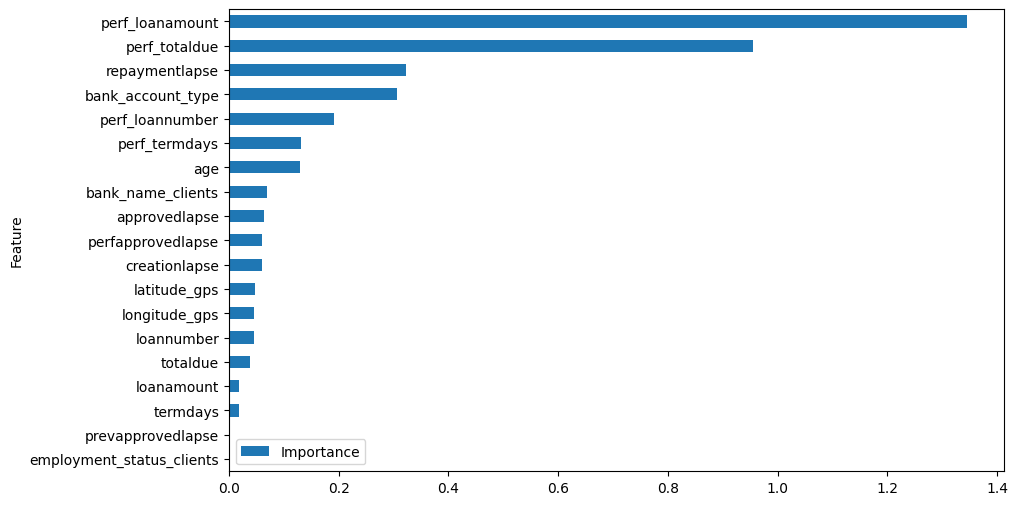

In [ ]:
coefficients = logreg.coef_[0]


feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))


In [ ]:
y_test.value_counts()

good_bad_flag
1    2204
0     531
Name: count, dtype: int64

In [ ]:
y_train.value_counts()

good_bad_flag
1    8942
0    1996
Name: count, dtype: int64

In [ ]:
#confusion matrix for our model
cm =confusion_matrix(y_test, y_pred_test)

In [ ]:
cm

array([[   4,  527],
       [   3, 2201]])

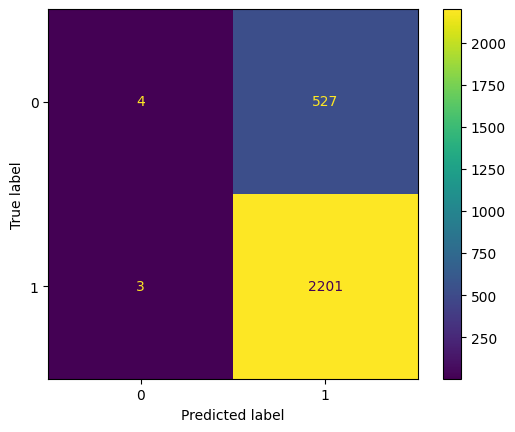

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.57      0.01      0.01       531
           1       0.81      1.00      0.89      2204

    accuracy                           0.81      2735
   macro avg       0.69      0.50      0.45      2735
weighted avg       0.76      0.81      0.72      2735



Let's now apply SMOTE to deal with the imbalanced data

In [ ]:
X = loan_data.drop(['good_bad_flag'], axis=1)
y = loan_data['good_bad_flag']

In [ ]:
#SMOTE is an oversampling technique that creates new data from existing
#for the minority class in this case, bad loans
#the sampling strategy chosen is all, no change with it being 'minority'
smote_algo = SMOTE(sampling_strategy='all',random_state=0)
smote_data_X, smote_data_Y = smote_algo.fit_resample(X,y)
smote_data_X = pd.DataFrame(data=smote_data_X, columns=X.columns)
smote_data_Y = pd.DataFrame(data=smote_data_Y, columns=['good_bad_flag'])

In [ ]:
smote_data = smote_data_X
smote_data['good_bad_flag'] = smote_data_Y['good_bad_flag']

In [ ]:
smote_data_Y['good_bad_flag'].value_counts()

good_bad_flag
1    11146
0    11146
Name: count, dtype: int64

In [ ]:
smote_data.drop_duplicates(keep="first", inplace=True) #removing duplicate data if any
smote_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22292 entries, 0 to 22291
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bank_account_type          22292 non-null  int64  
 1   longitude_gps              22292 non-null  float64
 2   latitude_gps               22292 non-null  float64
 3   bank_name_clients          22292 non-null  int64  
 4   employment_status_clients  22292 non-null  int64  
 5   loannumber                 22292 non-null  int64  
 6   loanamount                 22292 non-null  float64
 7   totaldue                   22292 non-null  float64
 8   termdays                   22292 non-null  int64  
 9   perf_loannumber            22292 non-null  int64  
 10  perf_loanamount            22292 non-null  float64
 11  perf_totaldue              22292 non-null  float64
 12  perf_termdays              22292 non-null  int64  
 13  age                        22292 non-null  flo

Let's try building our logistic regression model again.

In [ ]:
X = smote_data.drop(['good_bad_flag'],axis=1)
y = smote_data['good_bad_flag']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 2)

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape, X_test.shape

((17833, 19), (4459, 19))

In [ ]:
logreg = LogisticRegression(solver='liblinear', random_state=3)

In [ ]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=3, solver='liblinear')

In [ ]:
y_pred_test = logreg.predict(X_test)
y_pred_test

array([1, 1, 0, ..., 0, 1, 1])

In [ ]:
print('Model accuracy score(test): ', accuracy_score(y_test, y_pred_test))

Model accuracy score(test):  0.6225611123570307


In [ ]:
y_pred_train = logreg.predict(X_train)

print('Model accuracy score(train): ', accuracy_score(y_train, y_pred_train))

Model accuracy score(train):  0.5921606011327315


<Axes: ylabel='Feature'>

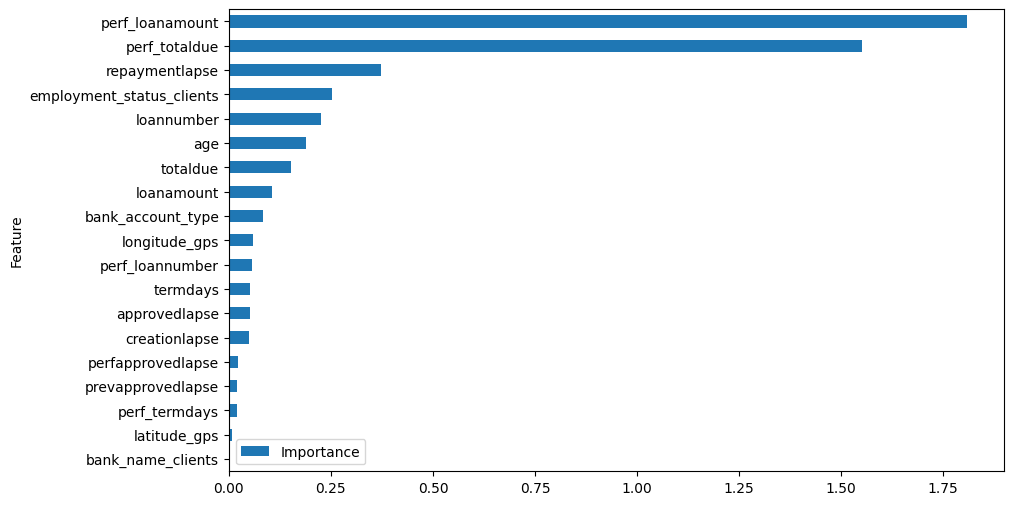

In [ ]:
coefficients = logreg.coef_[0]


feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))


In [ ]:
y_test.value_counts()

good_bad_flag
0    2297
1    2162
Name: count, dtype: int64

In [ ]:
cm1 =confusion_matrix(y_test, y_pred_test)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=logreg.classes_)

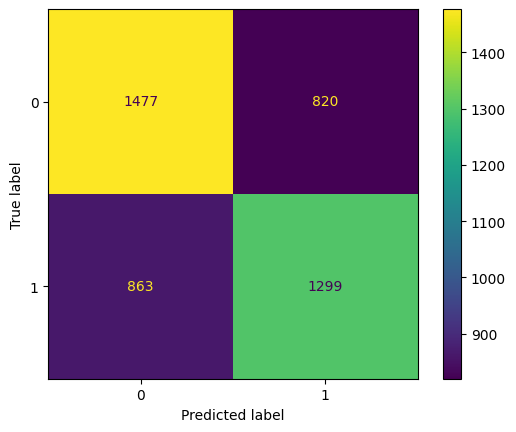

In [ ]:
disp.plot()

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.63      0.64      0.64      2297
           1       0.61      0.60      0.61      2162

    accuracy                           0.62      4459
   macro avg       0.62      0.62      0.62      4459
weighted avg       0.62      0.62      0.62      4459



The random forest results were unsatisfactory so let's ignore them for now and focus on other models.

In [ ]:
#we're going to build three models testing out a different number of nearest neighbours to
#see which number is best performing

#model where n_neighbors = 1
knnr = KNeighborsClassifier(n_neighbors = 1, metric='minkowski',p=2)

In [ ]:
knnr.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
y_pred = knnr.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2297
           1       0.91      0.84      0.87      2162

    accuracy                           0.88      4459
   macro avg       0.88      0.88      0.88      4459
weighted avg       0.88      0.88      0.88      4459



In [ ]:
train_x, val_x, train_y, val_y= train_test_split(X,y,test_size= 0.2, random_state= 42)

Rf= RandomForestClassifier(n_estimators= 300, random_state= 0)
Ab= AdaBoostClassifier(n_estimators= 200, learning_rate= 0.1)
Rf.fit(train_x,train_y)
pred= Rf.predict(val_x)
print("accuracy score:",accuracy_score(pred,val_y))


accuracy score: 0.9508858488450325


In [ ]:
print(classification_report(val_y, pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2185
           1       0.96      0.94      0.95      2274

    accuracy                           0.95      4459
   macro avg       0.95      0.95      0.95      4459
weighted avg       0.95      0.95      0.95      4459



<Axes: >

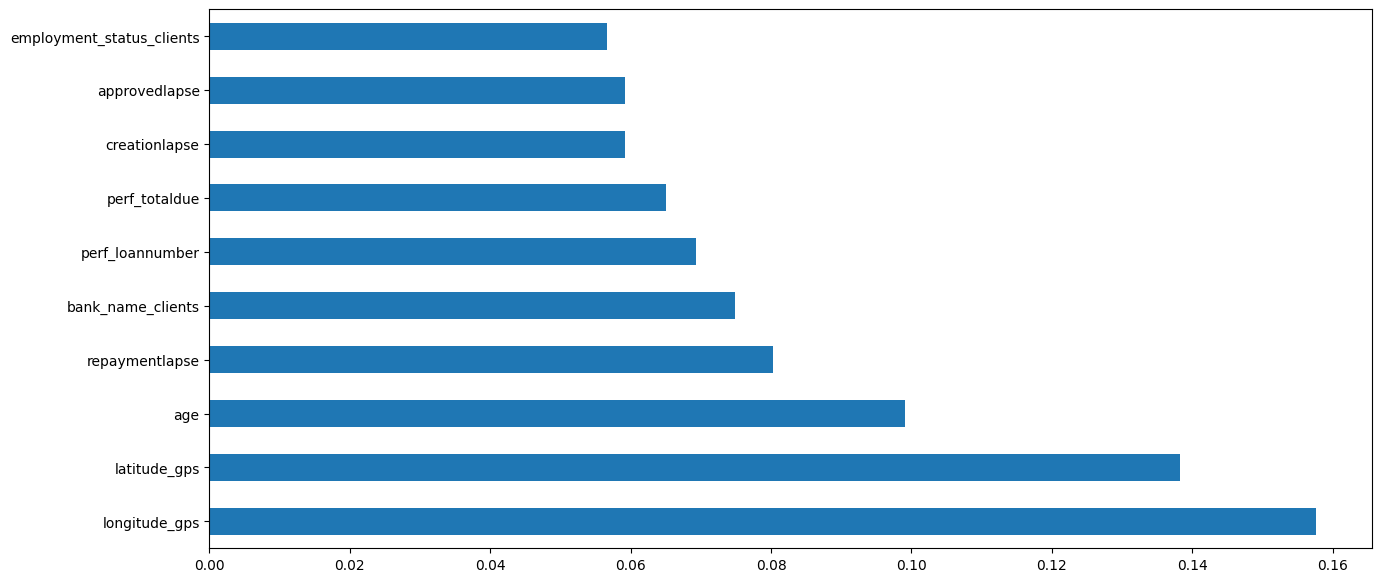

In [ ]:
#feature importance for Random ForestClassifier

%matplotlib inline
plt.figure(figsize=(15,7))
feat_importances = pd.Series(Rf.feature_importances_, index = X.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [ ]:
print(classification_report(y_test, y_pred))

Random Forest is the most accurate model so let's now introduce the